# Validation of Wind & Wave data from Satellite Altimetry with Buoys observations

## Purpose

In this Notebook, we are looking at the consistency of the wind speed and significant wave height between altimeters and observations from the buoy stations moored in the domain.

## Methodology

1. The first step is to keep only the valid significant wave height satellite observations on the grounds that there are many outliers owing to land contamination and the sensitivity of altimeters to clouds and low rain. The criteria are included and described in the references. We keep the satellite wind speed data correspondingly. 
2. To create a colocation algorithm, first we detect and keep satellite observations in specific distance from each buoy's location. The domain of interest is located close to the coast, therefore the distance of $10km$ is chosen. For every observation in the specific distance limit, we compute the time difference between each satellite observation and each buoy observation. We keep only the observations with a time difference of 30 minutes.
3. The algorithm is independent of the compared variable. It can be used for comparing either wind speed or significant wave height.

## Work in Progress - improvements

1. Correct the Bias estimation.
2. Improve the figures

## Results

In [5]:
#data manipulation
from pathlib import Path
import numpy as np
from numpy import percentile
from datetime import datetime, timedelta
import xarray as xr
import pandas as pd
import glob
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from math import sqrt
from scipy import stats
from scipy.stats import gaussian_kde
from scipy.constants import g, pi


#double iteration in pandas
from itertools import product

#compute distance between two points on earth
from haversine import haversine, haversine_vector, Unit

#mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#import gdal

#colorbars
import cmocean
import cmaps

#plotting
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
import matplotlib.patches as patches
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors

import warnings; warnings.simplefilter('ignore')


%matplotlib inline

## Input Data

### SARAL-AltiKa

In [50]:
altika1 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/altika_phase1_qc.txt',  sep='\t')
altika2 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/altika_phase2_qc_gdrf_full.txt',  sep='\t')

altika = pd.concat([altika1,altika2],axis=0)

### Jason 3

In [51]:
jason31 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/jason3_phase1_qc.txt',  sep='\t')
jason32 = pd.read_csv('C:/Users/panmits86/Desktop/Python\data/valid_altimeter_data/jason3_phase2_gdrd_qc.txt',  sep='\t')

jason3 = pd.concat([jason31,jason32],axis=0)

### Cryosat 2

In [52]:
cryosat21 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/cryosat2_qc_1.txt',  sep='\t')
cryosat22 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/cryosat2_qc_2.txt',  sep='\t')

cryosat2 = pd.concat([cryosat21,cryosat22],axis=0)

### Sentinel 3

In [53]:
# sentinel3 A & B

sentinel31 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/sentinel3a_qc_1.txt',  sep='\t')
sentinel32 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/sentinel3b_qc_1.txt',  sep='\t')
sentinel33 = pd.read_csv('C:/Users/panmits86/Desktop/Python/data/valid_altimeter_data/sentinel3ab_qc_2.txt',  sep='\t')

sentinel3 = pd.concat([sentinel31,sentinel32,sentinel33],axis=0)

In [54]:
altika = altika.reset_index()
altika = altika.drop(['index'], axis=1)
altika['time'] = pd.to_datetime(altika['time'])


jason3 = jason3.reset_index()
jason3 = jason3.drop(['index'], axis=1)
jason3['time'] = pd.to_datetime(jason3['time'])


cryosat2 = cryosat2.reset_index()
cryosat2 = cryosat2.drop(['index'], axis=1)
cryosat2['time'] = pd.to_datetime(cryosat2['time'])


sentinel3 = sentinel3.reset_index()
sentinel3 = sentinel3.drop(['index'], axis=1)
sentinel3['time'] = pd.to_datetime(sentinel3['time'])

### Buoys

In [6]:
# input buoys coordinates (buoy_coords parameter)

buoys = pd.read_excel('buoys.xlsx', header=0, index_col=None, usecols="C:E")

b44017 = (buoys['Latitude'][3],buoys['Longitude'][3]+360)
b44025 = (buoys['Latitude'][2],buoys['Longitude'][2]+360)
b44065 = (buoys['Latitude'][4],buoys['Longitude'][4]+360)
b44020 = (buoys['Latitude'][1],buoys['Longitude'][1]+360)
b44097 = (buoys['Latitude'][0],buoys['Longitude'][0]+360)
b44039 = (buoys['Latitude'][5],buoys['Longitude'][5]+360)
b44008 = (buoys['Latitude'][6],buoys['Longitude'][6]+360)
b44066 = (buoys['Latitude'][7],buoys['Longitude'][7]+360)
b44091 = (buoys['Latitude'][8],buoys['Longitude'][8]+360)
b44013 = (buoys['Latitude'][9],buoys['Longitude'][9]+360)
b44090 = (buoys['Latitude'][10],buoys['Longitude'][10]+360)
b44018 = (buoys['Latitude'][11],buoys['Longitude'][11]+360)

In [7]:
# make a parser to include minutes, hours, days, months, years in one column and convert to datetime
def parse(yr, mo, doy, hr, min):
    yr, mo, doy, hr, min = [int(x) for x in [yr, mo, doy, hr, min]]
    dt = datetime(yr - 0, mo, doy, hr, min)
    return dt

### Significant Wave Height

In [141]:
# read all buoy data files and concatenate them into one single pandas data frame and exclude wave height error values
# input for the buoy_data parameter (e.g. b44017_wind_wave)


# Buoy 44017

path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44017_1'
all_files = glob.glob(path + "/*.txt")

b44017_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44017_wave = b44017_wave[(b44017_wave.WVHT !=99) & (b44017_wave.WVHT > 0.1)]
b44017_wave.reset_index(inplace=True)
b44017_wave.drop('index', 1, inplace=True)


# Buoy 44025

path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44025_1'
all_files = glob.glob(path + "/*.txt")

b44025_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44025_wave = b44025_wave[(b44025_wave.WVHT !=99) & (b44025_wave.WVHT > 0.1)]
b44025_wave.reset_index(inplace=True)
b44025_wave.drop('index', 1, inplace=True)


# Buoy 44097

path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44097_1'
all_files = glob.glob(path + "/*.txt")

b44097_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44097_wave = b44097_wave[(b44097_wave.WVHT !=99) & (b44097_wave.WVHT > 0.1)]
b44097_wave.reset_index(inplace=True)
b44097_wave.drop('index', 1, inplace=True)


# Buoy 44065

path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44065_1'
all_files = glob.glob(path + "/*.txt")

b44065_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44065_wave = b44065_wave[(b44065_wave.WVHT !=99) & (b44065_wave.WVHT > 0.1)]
b44065_wave.reset_index(inplace=True)
b44065_wave.drop('index', 1, inplace=True)


# Buoy 44020

path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44020_1'
all_files = glob.glob(path + "/*.txt")

b44020_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44020_wave = b44020_wave[(b44020_wave.WVHT !=99) & (b44020_wave.WVHT > 0.1)]
b44020_wave.reset_index(inplace=True)
b44020_wave.drop('index', 1, inplace=True)


# Buoy 44039

path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44039_1'
all_files = glob.glob(path + "/*.txt")

b44039_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44039_wave = b44039_wave[(b44039_wave.WVHT !=99) & (b44039_wave.WVHT > 0.1)]
b44039_wave.reset_index(inplace=True)
b44039_wave.drop('index', 1, inplace=True)


# Buoy 44091

path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44091'
all_files = glob.glob(path + "/*.txt")

b44091_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44091_wave = b44091_wave[(b44091_wave.WVHT !=99) & (b44091_wave.WVHT > 0.1)]
b44091_wave.reset_index(inplace=True)
b44091_wave.drop('index', 1, inplace=True)


# Buoy 44008

path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44008'
all_files = glob.glob(path + "/*.txt")

b44008_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44008_wave = b44008_wave[(b44008_wave.WVHT !=99) & (b44008_wave.WVHT > 0.1)]
b44008_wave.reset_index(inplace=True)
b44008_wave.drop('index', 1, inplace=True)


# Buoy 44066

path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44066/2013-2019'
all_files = glob.glob(path + "/*.txt")

b44066_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44066_wave = b44066_wave[(b44066_wave.WVHT !=99) & (b44066_wave.WVHT > 0.1)]
b44066_wave.reset_index(inplace=True)
b44066_wave.drop('index', 1, inplace=True)


# Buoy 44013

path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44013'
all_files = glob.glob(path + "/*.txt")

b44013_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44013_wave = b44013_wave[(b44013_wave.WVHT !=99) & (b44013_wave.WVHT > 0.1)]
b44013_wave.reset_index(inplace=True)
b44013_wave.drop('index', 1, inplace=True)


# Buoy 44018

path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44018'
all_files = glob.glob(path + "/*.txt")

b44018_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44018_wave = b44018_wave[(b44018_wave.WVHT !=99) & (b44018_wave.WVHT > 0.1)]
b44018_wave.reset_index(inplace=True)
b44018_wave.drop('index', 1, inplace=True)


# Buoy 44090

path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44090'
all_files = glob.glob(path + "/*.txt")

b44090_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44090_wave = b44090_wave[(b44090_wave.WVHT !=99) & (b44090_wave.WVHT > 0.1)]
b44090_wave.reset_index(inplace=True)
b44090_wave.drop('index', 1, inplace=True)


# Buoy 44013

path = r'C:/Users/panmits86/Desktop/Python/data/buoys/Station_44013'
all_files = glob.glob(path + "/*.txt")

b44013_wave = pd.concat((pd.read_csv(f, delim_whitespace=True, 
                         skiprows=lambda x: x == 1, usecols=[0,1,2,3,4,6,8], header=0, date_parser=parse, 
                          parse_dates={'Date':['#YY','MM','DD','hh','mm']}) for f in all_files))
b44013_wave = b44013_wave[(b44013_wave.WVHT !=99) & (b44013_wave.WVHT > 0.1)]
b44013_wave.reset_index(inplace=True)
b44013_wave.drop('index', 1, inplace=True)

In [9]:
b44017_time = b44017_wave['Date']
b44025_time = b44025_wave['Date']
b44065_time = b44065_wave['Date']
b44020_time = b44020_wave['Date']
b44097_time = b44097_wave['Date']
b44039_time = b44039_wave['Date']
b44008_time = b44008_wave['Date']
b44091_time = b44091_wave['Date']
b44066_time = b44066_wave['Date']
b44013_time = b44013_wave['Date']
b44090_time = b44090_wave['Date']
b44018_time = b44018_wave['Date']

## Collocation

In [210]:
# SARAL-AltiKa
a1 = [(altika['lat'][n], altika['lon'][n]) for n in range(altika.shape[0])]

# Jason 3
a2 = [(jason3['lat'][n], jason3['lon'][n]) for n in range(jason3.shape[0])]

# Cryosat 2
b1 = [(cryosat2['lat'][n], cryosat2['lon'][n]) for n in range(cryosat2.shape[0])]

# Sentinel 3
c1 = [(sentinel3['lat'][n], sentinel3['lon'][n]) for n in range(sentinel3.shape[0])]

### Significant Wave Height

In [237]:
# Set the sampling radius in kilometers and the time window in minutes

radius = 10
time_window = 15

In [238]:
def collocation(buoy_coords,radius_km,buoy_data,buoy_time,time_window_min,altimeter_data,d):
    hav5 = haversine_vector([buoy_coords]*altimeter_data.shape[0],d, Unit.KILOMETERS)
    altimeter_data['Buoy-Sat. Distance (km)'] = pd.DataFrame(hav5, columns=['Buoy-Sat. Distance (km)'])

    radius = altimeter_data['Buoy-Sat. Distance (km)'] < radius_km
    colocated = altimeter_data[radius]
    colocated.reset_index(inplace=True)
    colocated.drop('index', 1, inplace=True)

    col = colocated['Buoy-Sat. Distance (km)'].to_numpy()

    sat_time = colocated['time'].reset_index()
    sat_time.drop('index', 1, inplace=True)
    
    b = colocated.to_numpy()
    c = buoy_data.to_numpy()

    bb1 = np.tile(b,(c.shape[0],1))
    cc1 = np.repeat(c,b.shape[0],axis=0)

    sat = sat_time['time'].to_numpy()
    buoy = buoy_time.to_numpy()

    buoy1 = buoy[:,np.newaxis]

    a = sat-buoy1
    aa = a/np.timedelta64(1,'m')

    aaa = np.ravel(aa)
    aaaa1 = aaa[:,np.newaxis]
    
    dd1=np.concatenate((cc1,bb1,aaaa1),axis=1)
    
    ddd1 = dd1[np.where(np.absolute(dd1[:,9])<time_window_min)]
    dddd1 = pd.DataFrame(ddd1)
    dddd1.columns = ['Buoy Time','Buoy Wind Speed','Buoy Wave Height', 'Altimeter Time', 'Altimeter lon', 'Altimeter lat',
                'Altimeter Wave Height', 'Altimeter Wind Speed', 'Buoy-Sat. Distance (km)', 'Time Difference (min.)']
    
    collocated_data = dddd1
    
    return collocated_data

### SARAL-AltiKa

In [212]:
altika1 = collocation(b44017,radius,b44017_wave,b44017_time,time_window,altika,a1)
altika2 = collocation(b44025,radius,b44025_wave,b44025_time,time_window,altika,a1)
altika4 = collocation(b44065,radius,b44065_wave,b44065_time,time_window,altika,a1)
altika5 = collocation(b44020,radius,b44020_wave,b44020_time,time_window,altika,a1)
altika6 = collocation(b44039,radius,b44039_wave,b44039_time,time_window,altika,a1)
altika8 = collocation(b44008,radius,b44008_wave,b44008_time,time_window,altika,a1)
altika9 = collocation(b44066,radius,b44066_wave,b44066_time,time_window,altika,a1)
altika10 = collocation(b44013,radius,b44013_wave,b44013_time,time_window,altika,a1)
altika12 = collocation(b44018,radius,b44018_wave,b44018_time,time_window,altika,a1)

In [215]:
# same process but lower time window for CDIP buoys

altika3 = collocation(b44097,radius,b44097_wave,b44097_time,time_window,altika,a1)
altika7 = collocation(b44091,radius,b44091_wave,b44091_time,time_window,altika,a1)
altika11 = collocation(b44090,radius,b44090_wave,b44090_time,time_window,altika,a1)

In [216]:
# merge collocated data from different buoys (optional)

merge = [altika1,altika2,altika3,altika4,altika5,altika6,altika7,altika8,altika9,altika10,altika11,altika12]
saral_wave = pd.concat(merge)
len(saral_wave)

902

In [217]:
saral_wave.loc[saral_wave['Buoy Wind Speed'] == 99.0,'Buoy Wind Speed'] = np.nan
saral_wave.loc[saral_wave['Buoy Wave Height'] == 99.0,'Buoy Wave Height'] = np.nan

### Jason 3

In [220]:
jason31 = collocation(b44017,radius,b44017_wave,b44017_time,time_window,jason3,a2)
jason32 = collocation(b44025,radius,b44025_wave,b44025_time,time_window,jason3,a2)
jason34 = collocation(b44065,radius,b44065_wave,b44065_time,time_window,jason3,a2)
jason35 = collocation(b44020,radius,b44020_wave,b44020_time,time_window,jason3,a2)
jason36 = collocation(b44039,radius,b44039_wave,b44039_time,time_window,jason3,a2)
jason38 = collocation(b44008,radius,b44008_wave,b44008_time,time_window,jason3,a2)
jason39 = collocation(b44066,radius,b44066_wave,b44066_time,time_window,jason3,a2)
jason310 = collocation(b44013,radius,b44013_wave,b44013_time,time_window,jason3,a2)
jason312 = collocation(b44018,radius,b44018_wave,b44018_time,time_window,jason3,a2)

In [223]:
# same process but with reduced time window for CDIP buoys

jason33 = collocation(b44097,radius,b44097_wave,b44097_time,time_window,jason3,a2)
jason37 = collocation(b44091,radius,b44091_wave,b44091_time,time_window,jason3,a2)
jason311 = collocation(b44090,radius,b44090_wave,b44090_time,time_window,jason3,a2)

In [224]:
# merge collocated data from different buoys (optional)

merge = [jason31,jason32,jason33,jason34,jason35,jason36,jason37,jason38,jason39,jason310,jason311,jason312]
jason3_wave = pd.concat(merge)
len(jason3_wave)

1293

In [225]:
jason3_wave.loc[jason3_wave['Buoy Wind Speed'] == 99.0,'Buoy Wind Speed'] = np.nan
jason3_wave.loc[jason3_wave['Buoy Wave Height'] == 99.0,'Buoy Wave Height'] = np.nan

### Cryosat 2

In [228]:
cryosat21 = collocation(b44017,radius,b44017_wave,b44017_time,time_window,cryosat2,b1)
cryosat22 = collocation(b44025,radius,b44025_wave,b44025_time,time_window,cryosat2,b1)
cryosat24 = collocation(b44065,radius,b44065_wave,b44065_time,time_window,cryosat2,b1)
cryosat25 = collocation(b44020,radius,b44020_wave,b44020_time,time_window,cryosat2,b1)
cryosat26 = collocation(b44039,radius,b44039_wave,b44039_time,time_window,cryosat2,b1)
cryosat28 = collocation(b44008,radius,b44008_wave,b44008_time,time_window,cryosat2,b1)
cryosat29 = collocation(b44066,radius,b44066_wave,b44066_time,time_window,cryosat2,b1)
cryosat210 = collocation(b44013,radius,b44013_wave,b44013_time,time_window,cryosat2,b1)
cryosat212 = collocation(b44018,radius,b44018_wave,b44018_time,time_window,cryosat2,b1)

In [231]:
# same process but with reduced time window for CDIP buoys

cryosat23 = collocation(b44097,radius,b44097_wave,b44097_time,time_window,cryosat2,b1)
cryosat27 = collocation(b44091,radius,b44091_wave,b44091_time,time_window,cryosat2,b1)
cryosat211 = collocation(b44090,radius,b44090_wave,b44090_time,time_window,cryosat2,b1)

In [232]:
# merge collocated data from different buoys (optional)

merge = [cryosat21,cryosat22,cryosat23,cryosat24,cryosat25,cryosat26,cryosat27,cryosat28,cryosat29,cryosat210,cryosat211,cryosat212]
cryosat2_wave = pd.concat(merge)
len(cryosat2_wave)

904

In [233]:
cryosat2_wave.loc[cryosat2_wave['Buoy Wind Speed'] == 99.0,'Buoy Wind Speed'] = np.nan
cryosat2_wave.loc[cryosat2_wave['Buoy Wave Height'] == 99.0,'Buoy Wave Height'] = np.nan

### Sentinel 3

In [236]:
sentinel31 = collocation(b44017,radius,b44017_wave,b44017_time,time_window,sentinel3,c1)
sentinel32 = collocation(b44025,radius,b44025_wave,b44025_time,time_window,sentinel3,c1)
sentinel34 = collocation(b44065,radius,b44065_wave,b44065_time,time_window,sentinel3,c1)
sentinel35 = collocation(b44020,radius,b44020_wave,b44020_time,time_window,sentinel3,c1)
sentinel36 = collocation(b44039,radius,b44039_wave,b44039_time,time_window,sentinel3,c1)
sentinel38 = collocation(b44008,radius,b44008_wave,b44008_time,time_window,sentinel3,c1)
sentinel39 = collocation(b44066,radius,b44066_wave,b44066_time,time_window,sentinel3,c1)
sentinel310 = collocation(b44013,radius,b44013_wave,b44013_time,time_window,sentinel3,c1)
sentinel312 = collocation(b44018,radius,b44018_wave,b44018_time,time_window,sentinel3,c1)

In [239]:
# same process but with reduced time window for CDIP buoys

sentinel33 = collocation(b44097,radius,b44097_wave,b44097_time,time_window,sentinel3,c1)
sentinel37 = collocation(b44091,radius,b44091_wave,b44091_time,time_window,sentinel3,c1)
sentinel311 = collocation(b44090,radius,b44090_wave,b44090_time,time_window,sentinel3,c1)

In [240]:
# merge collocated data from different buoys (optional)

merge = [sentinel31,sentinel32,sentinel33,sentinel34,sentinel35,sentinel36,sentinel37,sentinel38,sentinel39,sentinel310,sentinel311,sentinel312]
sentinel3a_wave = pd.concat(merge)
len(sentinel3a_wave)

688

In [241]:
sentinel3a_wave.loc[sentinel3a_wave['Buoy Wind Speed'] == 99.0,'Buoy Wind Speed'] = np.nan
sentinel3a_wave.loc[sentinel3a_wave['Buoy Wave Height'] == 99.0,'Buoy Wave Height'] = np.nan

### Validation (Regression Analysis)

### Significant Wave Height

In [177]:
data0 = saral_wave.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

df0 = data0.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
df0 = df0.apply(pd.to_numeric, errors='coerce')
df0 = df0.resample('D').mean()
df0 = df0.dropna()



data1 = cryosat2_wave.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

df1 = data1.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
df1 = df1.apply(pd.to_numeric, errors='coerce')
df1 = df1.resample('D').mean()
df1 = df1.dropna()



data2 = sentinel3a_wave.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

df2 = data2.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
df2 = df2.apply(pd.to_numeric, errors='coerce')
df2 = df2.resample('D').mean()
df2 = df2.dropna()



data3 = jason3_wave.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

df3 = data3.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
df3 = df3.apply(pd.to_numeric, errors='coerce')
df3 = df3.resample('D').mean()
df3 = df3.dropna()


In [178]:
# Linear Regression

xx0 = df0['Buoy Wave Height']

yy0 = df0['Altimeter Wave Height']

model0 = LinearRegression(fit_intercept=True)

model0.fit(xx0[:, np.newaxis], yy0)

x1fit0 = np.linspace(0, 6, len(xx0))
y1fit0 = model0.predict(x1fit0[:, np.newaxis])



xx1 = df1['Buoy Wave Height']

yy1 = df1['Altimeter Wave Height']

model1 = LinearRegression(fit_intercept=True)
#model1 = RANSACRegressor()

model1.fit(xx1[:, np.newaxis], yy1)

x1fit1 = np.linspace(0, 6, len(xx1))
y1fit1 = model1.predict(x1fit1[:, np.newaxis])



xx2 = df2['Buoy Wave Height']

yy2 = df2['Altimeter Wave Height']

#model2 = LinearRegression(fit_intercept=True)
model2 = LinearRegression()

model2.fit(xx2[:, np.newaxis], yy2)

x1fit2 = np.linspace(0, 6, len(xx2))
y1fit2 = model2.predict(x1fit2[:, np.newaxis])



xx3 = df3['Buoy Wave Height']

yy3 = df3['Altimeter Wave Height']

model3 = LinearRegression(fit_intercept=True)
#model3 = RANSACRegressor()

model3.fit(xx3[:, np.newaxis], yy3)

x1fit3 = np.linspace(0, 6, len(xx3))
y1fit3 = model3.predict(x1fit3[:, np.newaxis])

In [179]:
# Calculate Bias 

ds0 = xx0 - yy0

bias0 = abs(ds0.sum() / len(ds0))
bias0


ds1 = xx1 - yy1

bias1 = abs(ds1.sum() / len(ds1))
bias1


ds2 = xx2 - yy2

bias2 = abs(ds2.sum() / len(ds2))
bias2


ds3 = xx3 - yy3

bias3 = abs(ds3.sum() / len(ds3))
bias3

0.03379457410152977

In [180]:
# Calculate Scatter Index

df_squared0 = (ds0)**2

si0 = np.sqrt(df_squared0.sum() / len(df_squared0)) / (xx0.sum() / len(xx0))
si0


df_squared1 = (ds1)**2

si1 = np.sqrt(df_squared1.sum() / len(df_squared1)) / (xx1.sum() / len(xx1))
si1


df_squared2 = (ds2)**2

si2 = np.sqrt(df_squared2.sum() / len(df_squared2)) / (xx2.sum() / len(xx2))
si2


df_squared3 = (ds3)**2

si3 = np.sqrt(df_squared3.sum() / len(df_squared3)) / (xx3.sum() / len(xx3))
si3

0.16471008616615784

In [181]:
si0 = np.sqrt((((xx0-np.average(xx0))-(yy0-np.average(yy0)))**2).sum() / len(xx0)) / np.average(xx0)
si1 = np.sqrt((((xx1-np.average(xx1))-(yy1-np.average(yy1)))**2).sum() / len(xx1)) / np.average(xx1)
si2 = np.sqrt((((xx2-np.average(xx2))-(yy2-np.average(yy2)))**2).sum() / len(xx2)) / np.average(xx2)
si3 = np.sqrt((((xx3-np.average(xx3))-(yy3-np.average(yy3)))**2).sum() / len(xx3)) / np.average(xx3)
si0, si3


(0.11556427088332, 0.16277644933617186)

In [182]:
rmse0 = np.sqrt(np.average((xx0 - yy0)**2))
rmse1 = np.sqrt(np.average((xx1 - yy1)**2))
rmse2 = np.sqrt(np.average((xx2 - yy2)**2))
rmse3 = np.sqrt(np.average((xx3 - yy3)**2))
rmse0, rmse3


(0.1307191147068927, 0.22119891522045984)

In [183]:
# Pearson's Correlation

rho0 = stats.pearsonr(xx0, yy0)[0]
rho0


rho1 = stats.pearsonr(xx1, yy1)[0]
rho1


rho2 = stats.pearsonr(xx2, yy2)[0]
rho2


rho3 = stats.pearsonr(xx3, yy3)[0]
rho3

0.977293887743021

In [116]:
# Statistics of the Regression line

a0=model0.coef_
b0=model0.intercept_


scores_mean0 = list()
scores_std0 = list()

scores0 = cross_validate(model0, xx0[:, np.newaxis], yy0, scoring=['r2', 'neg_root_mean_squared_error'], cv=6)

#rsquared0 = np.mean(scores0['test_r2'])
#rmse0 = -np.mean(scores0['test_neg_root_mean_squared_error'])
#rmsee0 = np.std(scores0['test_neg_root_mean_squared_error'])
N0=len(df0)



a11=model1.coef_
b11=model1.intercept_

#a11=model1.estimator_.coef_
#b11=model1.estimator_.intercept_

scores_mean1 = list()
scores_std1 = list()

scores1 = cross_validate(model1, xx1[:, np.newaxis], yy1, scoring=['r2', 'neg_root_mean_squared_error'], cv=6)

#rsquared1 = np.mean(scores1['test_r2'])
#rmse1 = -np.mean(scores1['test_neg_root_mean_squared_error'])
#rmsee1 = np.std(scores1['test_neg_root_mean_squared_error'])
N1=len(df1)



a2=model2.coef_
b2=model2.intercept_
#a2=model2.estimator_.coef_
#b2=model2.estimator_.intercept_

scores_mean2 = list()
scores_std2 = list()

scores2 = cross_validate(model2, xx2[:, np.newaxis], yy2, scoring=['r2', 'neg_root_mean_squared_error'], cv=6)

#rsquared2 = np.mean(scores2['test_r2'])
#rmse2 = -np.mean(scores2['test_neg_root_mean_squared_error'])
#rmsee2 = np.std(scores2['test_neg_root_mean_squared_error'])
N2=len(df2)



a3=model3.coef_
b3=model3.intercept_

#a3=model3.estimator_.coef_
#b3=model3.estimator_.intercept_

scores_mean3 = list()
scores_std3 = list()

scores3 = cross_validate(model3, xx3[:, np.newaxis], yy3, scoring=['r2', 'neg_root_mean_squared_error'], cv=6)

#rsquared3 = np.mean(scores3['test_r2'])
#rmse3 = -np.mean(scores3['test_neg_root_mean_squared_error'])
#rmsee3 = np.std(scores3['test_neg_root_mean_squared_error'])
N3=len(df3)

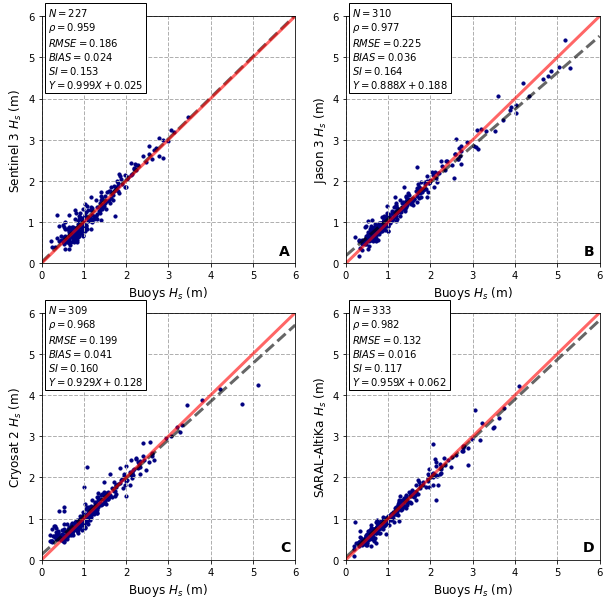

In [134]:
from itertools import count
fig, ax_lst = plt.subplots(2, 2,figsize=(10, 10), gridspec_kw={'hspace': 0.2, 'wspace': 0.2})
fig.tight_layout()

def label_subplots(ax_lst, *, upper_case=True,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    for ax, lab in zip(np.ravel(ax_lst), (chr(j) for j in count(start_ord))):
        ax.annotate(lab, (1, 0.1),
                    xytext=offset_points,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    ha='right', va='top', fontsize=14, fontweight='bold')


label_subplots(ax_lst, upper_case=True)

#figure 1

ax_lst[1,1].plot(x1fit0, y1fit0, linewidth=3, linestyle='--', color='k', alpha=0.6, label='Regression Line')
ax_lst[1,1].plot([0, 6], [0, 6], linestyle='-', linewidth=3, color='r', alpha=0.6, label='$Y=X$')

#kde0 = ax_lst[1,1].scatter(x_0, y_0, c=z_0, s=10, edgecolor='', marker='s', cmap=cmaps.BlAqGrYeOrRe ,label='data')
ax_lst[1,1].scatter(xx0, yy0, s=10, label='data',color='navy')

ax_lst[1,1].set_xlabel('Buoys $H_{s}$ (m)', fontsize=12)
ax_lst[1,1].set_ylabel('SARAL-AltiKa $H_{s}$ (m)', fontsize=12)
#plt.ylabel('Power Law $u_{10n}$ (m/s)', fontsize=14)
#plt.ylabel('Wind Speed $u$ (m/s) - No adjustment', fontsize=14)

ax_lst[1,1].set_xlim(0,6)
ax_lst[1,1].set_ylim(0,6)
ax_lst[1,1].grid(linestyle='--',linewidth=1)

props0 = dict(boxstyle='square', facecolor='white', alpha=1)

textstr0 = '\n'.join((r'$N=%i$' % (N0,), r'$\rho=%.3f$' % (rho0,), r'$RMSE=%.3f$' % (rmse0,), r'$BIAS=%.3f$' % (bias0,),
                     r'$SI=%.3f$' % (si0,), r'$Y=%.3fX + %.3f$' % (a0,b0,)))

ax_lst[1,1].text(0.15,4.25,textstr0,fontsize=10,bbox=props0)

#cbar = plt.colorbar(kde0, pad=0.02, aspect=40)

#cbar.ax.set_ylabel('')

#ax_lst[1,1].legend(loc='best')



#figure 2

ax_lst[0,1].plot(x1fit3, y1fit3, linewidth=3, linestyle='--', color='k', alpha=0.6, label='Regression Line')
ax_lst[0,1].plot([0, 6], [0, 6], linestyle='-', linewidth=3, color='r', alpha=0.6, label='$Y=X$')

#ax_lst[0,1].scatter(x_3, y_3, c=z_3, s=10, edgecolor='', marker='s', cmap=cmaps.BlAqGrYeOrRe ,label='data')
ax_lst[0,1].scatter(xx3, yy3, s=10, label='data',color='navy')

ax_lst[0,1].set_xlabel('Buoys $H_{s}$ (m)', fontsize=12)
ax_lst[0,1].set_ylabel('Jason 3 $H_{s}$ (m)', fontsize=12)
#plt.ylabel('Power Law $u_{10n}$ (m/s)', fontsize=14)
#plt.ylabel('Wind Speed $u$ (m/s) - No adjustment', fontsize=14)

ax_lst[0,1].set_xlim(0,6)
ax_lst[0,1].set_ylim(0,6)
ax_lst[0,1].grid(linestyle='--',linewidth=1)

props3 = dict(boxstyle='square', facecolor='white', alpha=1)

textstr3 = '\n'.join((r'$N=%i$' % (N3,), r'$\rho=%.3f$' % (rho3,), r'$RMSE=%.3f$' % (rmse3,), r'$BIAS=%.3f$' % (bias3,),
                     r'$SI=%.3f$' % (si3,), r'$Y=%.3fX + %.3f$' % (a3,b3,)))

ax_lst[0,1].text(0.15,4.25,textstr3,fontsize=10,bbox=props3)

#ax_lst[1,1].legend(loc='best')


#figure 3

ax_lst[1,0].plot(x1fit1, y1fit1, linewidth=3, linestyle='--', color='k', alpha=0.6, label='Regression Line')
#ax_lst[1,0].plot(x1fit1, y1fit11, linewidth=3, linestyle='--', color='k', alpha=0.6, label='Regression Line')
ax_lst[1,0].plot([0, 6], [0, 6], linestyle='-', linewidth=3, color='r', alpha=0.6, label='$Y=X$')

#ax_lst[1,0].scatter(x_1, y_1, c=z_1, s=10, edgecolor='', marker='s', cmap=cmaps.BlAqGrYeOrRe ,label='data')
ax_lst[1,0].scatter(xx1, yy1, s=10, label='data',color='navy')

ax_lst[1,0].set_xlabel('Buoys $H_{s}$ (m)', fontsize=12)
#plt.ylabel('$C_{d} = 1.4 \cdot 10^{-3}$ Parametrization $u_{10n}$ (m/s)', fontsize=12)
ax_lst[1,0].set_ylabel('Cryosat 2 $H_{s}$ (m)', fontsize=12)
#plt.ylabel('Wind Speed $u$ (m/s) - No adjustment', fontsize=14)

ax_lst[1,0].set_xlim(0,6)
ax_lst[1,0].set_ylim(0,6)
ax_lst[1,0].grid(linestyle='--',linewidth=1)

props1 = dict(boxstyle='square', facecolor='white', alpha=1)

textstr1 = '\n'.join((r'$N=%i$' % (N1,), r'$\rho=%.3f$' % (rho1,), r'$RMSE=%.3f$' % (rmse1,), r'$BIAS=%.3f$' % (bias1,),
                     r'$SI=%.3f$' % (si1,), r'$Y=%.3fX + %.3f$' % (a11,b11,)))

ax_lst[1,0].text(0.15,4.25,textstr1,fontsize=10,bbox=props1)

#ax_lst[1,1].legend(loc='best')


#figure 4

ax_lst[0,0].plot(x1fit2, y1fit2, linewidth=3, linestyle='--', color='k', alpha=0.6, label='Regression Line')
ax_lst[0,0].plot([0, 6], [0, 6], linestyle='-', linewidth=3, color='r', alpha=0.6, label='$Y=X$')

#ax_lst[0,0].scatter(x_2, y_2, c=z_2, s=10, edgecolor='', marker='s', cmap=cmaps.BlAqGrYeOrRe ,label='data')
ax_lst[0,0].scatter(xx2, yy2, s=10, label='data',color='navy')

ax_lst[0,0].set_xlabel('Buoys $H_{s}$ (m)', fontsize=12)
#ax_lst[0,0].set_ylabel('$C_{d} = 1.2 \cdot 10^{-3}$ Parametrization $u_{10n}$ (m/s)', fontsize=12)
#ax_lst[0,0].ylabel('Power Law $u_{10n}$ (m/s)', fontsize=14)
ax_lst[0,0].set_ylabel('Sentinel 3 $H_{s}$ (m)', fontsize=12)

ax_lst[0,0].set_xlim(0,6)
ax_lst[0,0].set_ylim(0,6)
ax_lst[0,0].grid(linestyle='--',linewidth=1)

props2 = dict(boxstyle='square', facecolor='white', alpha=1)

textstr2 = '\n'.join((r'$N=%i$' % (N2,), r'$\rho=%.3f$' % (rho2,), r'$RMSE=%.3f$' % (rmse2,), r'$BIAS=%.3f$' % (bias2,),
                     r'$SI=%.3f$' % (si2,), r'$Y=%.3fX + %.3f$' % (a2,b2,)))

ax_lst[0,0].text(0.15,4.25,textstr2,fontsize=10,bbox=props2)

#ax_lst[1,1].legend(loc='best')



plt.savefig('validation_altimeters_wave_f.png', dpi=600, bbox_inches='tight')

In [ ]:
altika1 = collocation(b44017,radius,b44017_wave,b44017_time,time_window,altika,a1)
altika2 = collocation(b44025,radius,b44025_wave,b44025_time,time_window,altika,a1)
altika4 = collocation(b44065,radius,b44065_wave,b44065_time,time_window,altika,a1)
altika5 = collocation(b44020,radius,b44020_wave,b44020_time,time_window,altika,a1)
altika6 = collocation(b44039,radius,b44039_wave,b44039_time,time_window,altika,a1)
altika8 = collocation(b44008,radius,b44008_wave,b44008_time,time_window,altika,a1)
altika9 = collocation(b44066,radius,b44066_wave,b44066_time,time_window,altika,a1)
altika10 = collocation(b44013,radius,b44013_wave,b44013_time,time_window,altika,a1)
altika12 = collocation(b44018,radius,b44018_wave,b44018_time,time_window,altika,a1)

altika3 = collocation(b44097,radius,b44097_wave,b44097_time,time_window,altika,a1)
altika7 = collocation(b44091,radius,b44091_wave,b44091_time,time_window,altika,a1)
altika11 = collocation(b44090,radius,b44090_wave,b44090_time,time_window,altika,a1)

In [302]:
b44017_col = pd.concat([altika1,jason31,cryosat21,sentinel31],axis=0)
b44017_col = b44017_col.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

b44017_col = b44017_col.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
b44017_col = b44017_col.apply(pd.to_numeric, errors='coerce')
b44017_col = b44017_col.resample('D').mean()
b44017_col = b44017_col.dropna()
b44017_r = stats.pearsonr(b44017_col['Buoy Wave Height'], b44017_col['Altimeter Wave Height'])
b44017_rmse = np.sqrt(np.average((b44017_col['Buoy Wave Height'] - b44017_col['Altimeter Wave Height'])**2))
b44017_r, b44017_rmse

((0.975410316120372, 4.1097801113247544e-41), 0.18496865093460482)

In [301]:
b44025_col = pd.concat([altika2,jason32,cryosat22,sentinel32],axis=0)
b44025_col = b44025_col.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

b44025_col = b44025_col.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
b44025_col = b44025_col.apply(pd.to_numeric, errors='coerce')
b44025_col = b44025_col.resample('D').mean()
b44025_col = b44025_col.dropna()
b44025_r = stats.pearsonr(b44025_col['Buoy Wave Height'], b44025_col['Altimeter Wave Height'])
b44025_rmse = np.sqrt(np.average((b44025_col['Buoy Wave Height'] - b44025_col['Altimeter Wave Height'])**2))
b44025_r, b44025_rmse

((0.9742783430193054, 9.3321341046084e-107), 0.15463973739286035)

In [300]:
b44065_col = pd.concat([altika4,jason34,cryosat24,sentinel34],axis=0)
b44065_col = b44065_col.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

b44065_col = b44065_col.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
b44065_col = b44065_col.apply(pd.to_numeric, errors='coerce')
b44065_col = b44065_col.resample('D').mean()
b44065_col = b44065_col.dropna()
b44065_r = stats.pearsonr(b44065_col['Buoy Wave Height'], b44065_col['Altimeter Wave Height'])
b44065_rmse = np.sqrt(np.average((b44065_col['Buoy Wave Height'] - b44065_col['Altimeter Wave Height'])**2))
b44065_r, b44065_rmse

((0.928006274477735, 1.0160589323657234e-53), 0.20803472082062216)

In [293]:
b44097_col = pd.concat([altika3,jason33,cryosat23,sentinel33],axis=0)
b44097_col = b44097_col.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

b44097_col = b44097_col.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
b44097_col = b44097_col.apply(pd.to_numeric, errors='coerce')
b44097_col = b44097_col.resample('D').mean()
b44097_col = b44097_col.dropna()
b44097_r = stats.pearsonr(b44097_col['Buoy Wave Height'], b44097_col['Altimeter Wave Height'])
b44097_rmse = np.sqrt(np.average((b44097_col['Buoy Wave Height'] - b44097_col['Altimeter Wave Height'])**2))
b44097_r, b44097_rmse

((0.9819133622873554, 1.137145938497809e-190), 0.1382932666545038)

In [294]:
b44020_col = pd.concat([altika5,jason35,cryosat25,sentinel35],axis=0)
b44020_col = b44020_col.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

b44020_col = b44020_col.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
b44020_col = b44020_col.apply(pd.to_numeric, errors='coerce')
b44020_col = b44020_col.resample('D').mean()
b44020_col = b44020_col.dropna()
b44020_r = stats.pearsonr(b44020_col['Buoy Wave Height'], b44020_col['Altimeter Wave Height'])
b44020_rmse = np.sqrt(np.average((b44020_col['Buoy Wave Height'] - b44020_col['Altimeter Wave Height'])**2))
b44020_r, b44020_rmse

((0.8322432607170327, 1.3278853859380165e-19), 0.22412458729293813)

In [299]:
b44039_col = pd.concat([altika6,jason36,cryosat26,sentinel36],axis=0)
b44039_col = b44039_col.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

b44039_col = b44039_col.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
b44039_col = b44039_col.apply(pd.to_numeric, errors='coerce')
b44039_col = b44039_col.resample('D').mean()
b44039_col = b44039_col.dropna()
b44039_r = stats.pearsonr(b44039_col['Buoy Wave Height'], b44039_col['Altimeter Wave Height'])
b44039_rmse = np.sqrt(np.average((b44039_col['Buoy Wave Height'] - b44039_col['Altimeter Wave Height'])**2))
b44039_r, b44039_rmse

((0.9198972168978368, 7.43203959499596e-18), 0.1661837081613848)

In [298]:
b44091_col = pd.concat([altika7,jason37,cryosat27,sentinel37],axis=0)
b44091_col = b44091_col.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

b44091_col = b44091_col.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
b44091_col = b44091_col.apply(pd.to_numeric, errors='coerce')
b44091_col = b44091_col.resample('D').mean()
b44091_col = b44091_col.dropna()
b44091_r = stats.pearsonr(b44091_col['Buoy Wave Height'], b44091_col['Altimeter Wave Height'])
b44091_rmse = np.sqrt(np.average((b44091_col['Buoy Wave Height'] - b44091_col['Altimeter Wave Height'])**2))
b44091_r, b44091_rmse

((0.9844764662466515, 2.3078163316061552e-52), 0.12347430419474559)

In [297]:
b44008_col = pd.concat([altika8,jason38,cryosat28,sentinel38],axis=0)
b44008_col = b44008_col.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

b44008_col = b44008_col.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
b44008_col = b44008_col.apply(pd.to_numeric, errors='coerce')
b44008_col = b44008_col.resample('D').mean()
b44008_col = b44008_col.dropna()
b44008_r = stats.pearsonr(b44008_col['Buoy Wave Height'], b44008_col['Altimeter Wave Height'])
b44008_rmse = np.sqrt(np.average((b44008_col['Buoy Wave Height'] - b44008_col['Altimeter Wave Height'])**2))
b44008_r, b44008_rmse

((0.9897391809478984, 3.1829688168074847e-42), 0.15442563354308786)

In [303]:
b44066_col = pd.concat([altika9,jason39,cryosat29,sentinel39],axis=0)
b44066_col = b44066_col.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

b44066_col = b44066_col.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
b44066_col = b44066_col.apply(pd.to_numeric, errors='coerce')
b44066_col = b44066_col.resample('D').mean()
b44066_col = b44066_col.dropna()
b44066_r = stats.pearsonr(b44066_col['Buoy Wave Height'], b44066_col['Altimeter Wave Height'])
b44066_rmse = np.sqrt(np.average((b44066_col['Buoy Wave Height'] - b44066_col['Altimeter Wave Height'])**2))
b44066_r, b44066_rmse

((0.9756567190305044, 1.416898863248062e-151), 0.2593192672587288)

In [304]:
b44013_col = pd.concat([altika10,jason310,cryosat210,sentinel310],axis=0)
b44013_col = b44013_col.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

b44013_col = b44013_col.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
b44013_col = b44013_col.apply(pd.to_numeric, errors='coerce')
b44013_col = b44013_col.resample('D').mean()
b44013_col = b44013_col.dropna()
b44013_rmse = np.sqrt(np.average((b44013_col['Buoy Wave Height'] - b44013_col['Altimeter Wave Height'])**2))
b44013_r, b44013_rmse

((0.9597307735077281, 2.5547459914886897e-45), 0.24414868304289028)

In [296]:
b44090_col = pd.concat([altika11,jason311,cryosat211,sentinel311],axis=0)
b44090_col = b44090_col.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

b44090_col = b44090_col.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
b44090_col = b44090_col.apply(pd.to_numeric, errors='coerce')
b44090_col = b44090_col.resample('D').mean()
b44090_col = b44090_col.dropna()
b44090_rmse = np.sqrt(np.average((b44090_col['Buoy Wave Height'] - b44090_col['Altimeter Wave Height'])**2))
b44090_r, b44090_rmse

((0.8430882224094826, 1.6861777753106948e-45), 0.2545069658130237)

In [305]:
b44018_col = pd.concat([altika12,jason312,cryosat212,sentinel312],axis=0)
b44018_col = b44018_col.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

b44018_col = b44018_col.iloc[:,[1,5]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
b44018_col = b44018_col.apply(pd.to_numeric, errors='coerce')
b44018_col = b44018_col.resample('D').mean()
b44018_col = b44018_col.dropna()
b44018_rmse = np.sqrt(np.average((b44018_col['Buoy Wave Height'] - b44018_col['Altimeter Wave Height'])**2))
b44018_r, b44018_rmse

((0.9560402266326674, 3.742239843480286e-87), 0.2517899217373243)

In [326]:
buoys1 = pd.read_excel('buoys.xlsx', sheet_name="Sheet3", header=0, index_col=None, usecols="B:E")

for x,y,z in zip(buoys1['Longitude'], buoys1['Latitude'], buoys1['Buoy #']):print(x,y,z)

-69.248 40.504 44008


In [334]:
buoys2 = pd.read_excel('buoys.xlsx', sheet_name="Sheet2", header=0, index_col=None, usecols="B:E")

for x,y,z in zip(buoys2['Longitude'], buoys2['Latitude'], buoys2['Buoy #']):print(x,y,z)

-70.279 41.493 44020
-73.164 40.251 44025
-72.049 40.693 44017
-73.703 40.369 44065
-72.655 41.138 44039
-72.644 39.618 44066
-70.651 42.346 44013
-70.143 42.206 44018


In [336]:
buoys3 = pd.read_excel('buoys.xlsx', sheet_name="Sheet4", header=0, index_col=None, usecols="B:E")

for x,y,z in zip(buoys3['Longitude'], buoys3['Latitude'], buoys3['Buoy #']):print(x,y,z)

-71.127 40.969 44097
-73.769 39.778 44091
-70.329 41.84 44090


In [316]:
cor_coefw = {'buoy lon': [buoys['Longitude'][3], buoys['Longitude'][2], buoys['Longitude'][4], buoys['Longitude'][1], buoys['Longitude'][5],
                          buoys['Longitude'][6], buoys['Longitude'][7], buoys['Longitude'][9], buoys['Longitude'][10], buoys['Longitude'][11],
                         buoys['Longitude'][0], buoys['Longitude'][8]],
        'buoy lat': [buoys['Latitude'][3], buoys['Latitude'][2], buoys['Latitude'][4], buoys['Latitude'][1], buoys['Latitude'][5], 
                     buoys['Latitude'][6], buoys['Latitude'][7], buoys['Latitude'][9], buoys['Latitude'][10], buoys['Latitude'][11],
                   buoys['Latitude'][0], buoys['Latitude'][8]],
             'r': [b44017_r[0],b44025_r[0], b44065_r[0],b44020_r[0],b44039_r[0],b44008_r[0],b44066_r[0],b44013_r[0],b44090_r[0],b44018_r[0],
                  b44097_r[0], b44091_r[0]]}
cor_coeffw = pd.DataFrame(data=cor_coefw)
cor_coeffw

,buoy lon,buoy lat,r
0,-72.049,40.693,0.975410
1,-73.164,40.251,0.974278
2,-73.703,40.369,0.928006
3,-70.279,41.493,0.832243
4,-72.655,41.138,0.919897
5,-69.248,40.504,0.989739
6,-72.644,39.618,0.975657
7,-70.651,42.346,0.959731
8,-70.329,41.840,0.843088
9,-70.143,42.206,0.956040


In [308]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 12),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, alpha=0.)
    gl.xlabels_bottom = False
    gl.xlocator = mticker.FixedLocator([-75, -74, -73, -72, -71, -70, -69])
    gl.ylocator = mticker.FixedLocator([39, 40, 41, 42, 43])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

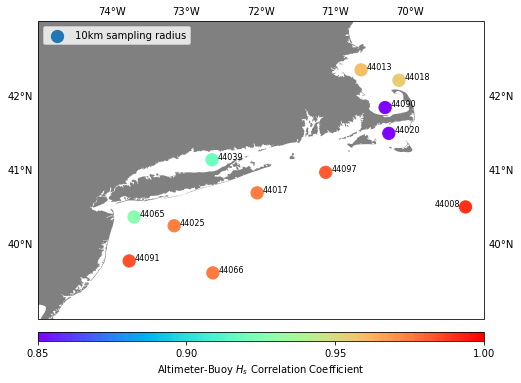

In [340]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-75, -69, 39, 43])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_h_L1_SNE1.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations.
#cmap=cmocean.cm.dense
cmap = cmaps.MPL_rainbow
bounds = np.array([0.85,0.9,0.95,1.])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0.85, vmax=1.)
cs2 = plt.scatter(cor_coeffw['buoy lon'], cor_coeffw['buoy lat'], c=cor_coeffw['r'], s=150, marker='o', cmap=cmap, norm=norm,
                  label='10km sampling radius')

for x,y,z in zip(buoys2['Longitude'], buoys2['Latitude'], buoys2['Buoy #']):
    ax.text(x+0.075, y+0.05, z,
                 verticalalignment='center', horizontalalignment='left', fontsize=8,
                 transform=ccrs.Geodetic())

for x,y,z in zip(buoys3['Longitude'], buoys3['Latitude'], buoys3['Buoy #']):
    ax.text(x+0.075, y+0.05, z,
                 verticalalignment='center', horizontalalignment='left', fontsize=8,
                 transform=ccrs.Geodetic())
    
ax.text(buoys1['Longitude'][0]-0.42, buoys1['Latitude'][0]+0.05, buoys1['Buoy #'][0], verticalalignment='center', 
                 horizontalalignment='left', fontsize=8,
                 transform=ccrs.Geodetic())


cax,kw = mpl.colorbar.make_axes(ax,location='bottom',pad=0.02,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='neither',**kw)
out.set_label('Altimeter-Buoy $H_{s}$ Correlation Coefficient',size=10)
ax.legend(loc='upper left',fontsize=10)
#ax.set_title('Map of SARAL-AltiKa Level 3 observations 10/2019-03-2020')
#ax.add_patch(mpatches.Circle(xy=[lon, lat], radius=r_ortho, color='red', alpha=0.1, transform=proj, zorder=30))
plt.savefig('buoy_altimeter_cor_coef_wave_f.png', dpi=300, bbox_inches='tight')

### Wind Speed 

In [184]:
data0 = saral_wave.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

df0 = data0.iloc[:,[0,6]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
df0 = df0.apply(pd.to_numeric, errors='coerce')
df0 = df0.resample('D').mean()
df0 = df0.dropna()



data1 = cryosat2_wave.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

df1 = data1.iloc[:,[0,6]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
df1 = df1.apply(pd.to_numeric, errors='coerce')
df1 = df1.resample('D').mean()
df1 = df1.dropna()



data2 = sentinel3a_wave.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

df2 = data2.iloc[:,[0,6]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
df2 = df2.apply(pd.to_numeric, errors='coerce')
df2 = df2.resample('D').mean()
df2 = df2.dropna()



data3 = jason3_wave.set_index('Buoy Time')

# select the columns that you want: [1,6] is for wind, [,] is for significant wave height data

df3 = data3.iloc[:,[0,6]]
#df1.reset_index(inplace=True)
#df1.drop('index', 1, inplace=True)
df3 = df3.apply(pd.to_numeric, errors='coerce')
df3 = df3.resample('D').mean()
df3 = df3.dropna()


In [185]:
# Linear Regression

xx0 = df0['Buoy Wind Speed']

yy0 = df0['Altimeter Wind Speed']

model0 = LinearRegression(fit_intercept=True)

model0.fit(xx0[:, np.newaxis], yy0)

x1fit0 = np.linspace(0, 20, len(xx0))
y1fit0 = model0.predict(x1fit0[:, np.newaxis])



xx1 = df1['Buoy Wind Speed']

yy1 = df1['Altimeter Wind Speed']

model1 = LinearRegression(fit_intercept=True)
#model1 = RANSACRegressor()

model1.fit(xx1[:, np.newaxis], yy1)

x1fit1 = np.linspace(0, 20, len(xx1))
y1fit1 = model1.predict(x1fit1[:, np.newaxis])



xx2 = df2['Buoy Wind Speed']

yy2 = df2['Altimeter Wind Speed']

#model2 = LinearRegression(fit_intercept=True)
model2 = LinearRegression()

model2.fit(xx2[:, np.newaxis], yy2)

x1fit2 = np.linspace(0, 20, len(xx2))
y1fit2 = model2.predict(x1fit2[:, np.newaxis])



xx3 = df3['Buoy Wind Speed']

yy3 = df3['Altimeter Wind Speed']

model3 = LinearRegression(fit_intercept=True)
#model3 = RANSACRegressor()

model3.fit(xx3[:, np.newaxis], yy3)

x1fit3 = np.linspace(0, 20, len(xx3))
y1fit3 = model3.predict(x1fit3[:, np.newaxis])

In [194]:
# Calculate Bias 

ds0 = xx0 - yy0

bias0 = abs(ds0.sum() / len(ds0))


ds1 = xx1 - yy1

bias1 = abs(ds1.sum() / len(ds1))


ds2 = xx2 - yy2

bias2 = abs(ds2.sum() / len(ds2))


ds3 = xx3 - yy3

bias3 = abs(ds3.sum() / len(ds3))


bias0, bias1, bias2, bias3

(0.2431133659740117,
 0.5149145431615169,
 0.2566413608634696,
 0.6932110901877172)

In [193]:
si0 = np.sqrt((((xx0-np.average(xx0))-(yy0-np.average(yy0)))**2).sum() / len(xx0)) / np.average(xx0)
si1 = np.sqrt((((xx1-np.average(xx1))-(yy1-np.average(yy1)))**2).sum() / len(xx1)) / np.average(xx1)
si2 = np.sqrt((((xx2-np.average(xx2))-(yy2-np.average(yy2)))**2).sum() / len(xx2)) / np.average(xx2)
si3 = np.sqrt((((xx3-np.average(xx3))-(yy3-np.average(yy3)))**2).sum() / len(xx3)) / np.average(xx3)
si0, si1, si2, si3

(0.20627962865754385,
 0.23533721150767423,
 0.20009855039274346,
 0.19726906700202165)

In [189]:
rmse0 = np.sqrt(np.average((xx0 - yy0)**2))
rmse1 = np.sqrt(np.average((xx1 - yy1)**2))
rmse2 = np.sqrt(np.average((xx2 - yy2)**2))
rmse3 = np.sqrt(np.average((xx3 - yy3)**2))
rmse0, rmse3

(1.3638563924506735, 1.6005371423598929)

In [195]:
# Pearson's Correlation

rho0 = stats.pearsonr(xx0, yy0)[0]


rho1 = stats.pearsonr(xx1, yy1)[0]


rho2 = stats.pearsonr(xx2, yy2)[0]


rho3 = stats.pearsonr(xx3, yy3)[0]

rho0, rho1, rho2, rho3

(0.9234047227274524, 0.9050821132877732, 0.891257362331201, 0.9267504192631766)

In [199]:
# Statistics of the Regression line

a0=model0.coef_
b0=model0.intercept_


scores_mean0 = list()
scores_std0 = list()

scores0 = cross_validate(model0, xx0[:, np.newaxis], yy0, scoring=['r2', 'neg_root_mean_squared_error'], cv=6)

N0=len(df0)



a1=model1.coef_
b1=model1.intercept_

#a11=model1.estimator_.coef_
#b11=model1.estimator_.intercept_

scores_mean1 = list()
scores_std1 = list()

scores1 = cross_validate(model1, xx1[:, np.newaxis], yy1, scoring=['r2', 'neg_root_mean_squared_error'], cv=6)

N1=len(df1)



a2=model2.coef_
b2=model2.intercept_
#a2=model2.estimator_.coef_
#b2=model2.estimator_.intercept_

scores_mean2 = list()
scores_std2 = list()

scores2 = cross_validate(model2, xx2[:, np.newaxis], yy2, scoring=['r2', 'neg_root_mean_squared_error'], cv=6)

N2=len(df2)



a3=model3.coef_
b3=model3.intercept_

#a3=model3.estimator_.coef_
#b3=model3.estimator_.intercept_

scores_mean3 = list()
scores_std3 = list()

scores3 = cross_validate(model3, xx3[:, np.newaxis], yy3, scoring=['r2', 'neg_root_mean_squared_error'], cv=6)

N3=len(df3)

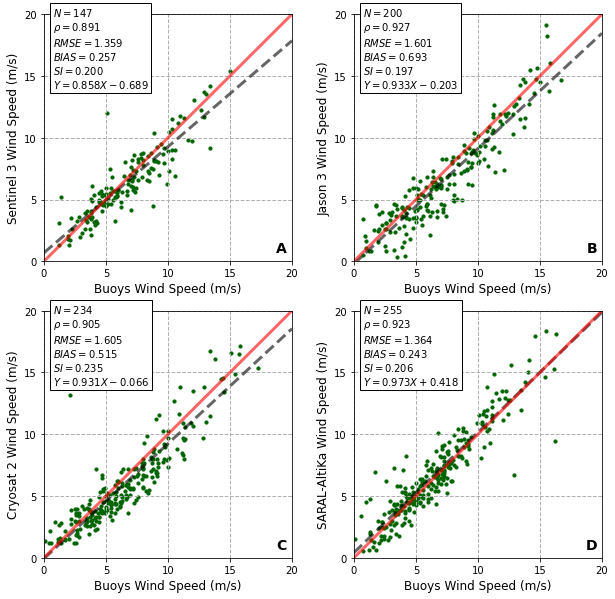

In [206]:
from itertools import count
fig, ax_lst = plt.subplots(2, 2,figsize=(10, 10.), gridspec_kw={'hspace': 0.2, 'wspace': 0.25})
fig.tight_layout()

def label_subplots(ax_lst, *, upper_case=True,
                   offset_points=(-5, -5)):
    start_ord = 65 if upper_case else 97
    for ax, lab in zip(np.ravel(ax_lst), (chr(j) for j in count(start_ord))):
        ax.annotate(lab, (1, 0.1),
                    xytext=offset_points,
                    xycoords='axes fraction',
                    textcoords='offset points',
                    ha='right', va='top', fontsize=14, fontweight='bold')


label_subplots(ax_lst, upper_case=True)

#figure 1

ax_lst[1,1].plot(x1fit0, y1fit0, linewidth=3, linestyle='--', color='k', alpha=0.6, label='Regression Line')
ax_lst[1,1].plot([0, 20], [0, 20], linestyle='-', linewidth=3, color='r', alpha=0.6, label='$Y=X$')

#kde0 = ax_lst[1,1].scatter(x_0, y_0, c=z_0, s=10, edgecolor='', marker='s', cmap=cmaps.BlAqGrYeOrRe ,label='data')
ax_lst[1,1].scatter(xx0, yy0, s=10, label='data',color='darkgreen')

ax_lst[1,1].set_xlabel('Buoys Wind Speed (m/s)', fontsize=12)
ax_lst[1,1].set_ylabel('SARAL-AltiKa Wind Speed (m/s)', fontsize=12)
#plt.ylabel('Power Law $u_{10n}$ (m/s)', fontsize=14)
#plt.ylabel('Wind Speed $u$ (m/s) - No adjustment', fontsize=14)

ax_lst[1,1].set_xlim(0,20)
ax_lst[1,1].set_ylim(0,20)
ax_lst[1,1].set_xticks(np.arange(0,22,5))
ax_lst[1,1].set_yticks(np.arange(0,22,5))
ax_lst[1,1].grid(linestyle='--',linewidth=1)

props0 = dict(boxstyle='square', facecolor='white', alpha=1)

textstr0 = '\n'.join((r'$N=%i$' % (N0,), r'$\rho=%.3f$' % (rho0,), r'$RMSE=%.3f$' % (rmse0,), r'$BIAS=%.3f$' % (bias0,),
                     r'$SI=%.3f$' % (si0,), r'$Y=%.3fX + %.3f$' % (a0,b0,)))

ax_lst[1,1].text(0.7,14,textstr0,fontsize=10,bbox=props0)

#cbar = plt.colorbar(kde0, pad=0.02, aspect=40)

#cbar.ax.set_ylabel('')

#ax_lst[1,1].legend(loc='best')

#figure 2

ax_lst[0,1].plot(x1fit3, y1fit3, linewidth=3, linestyle='--', color='k', alpha=0.6, label='Regression Line')
ax_lst[0,1].plot([0, 20], [0, 20], linestyle='-', linewidth=3, color='r', alpha=0.6, label='$Y=X$')

#ax_lst[0,1].scatter(x_3, y_3, c=z_3, s=10, edgecolor='', marker='s', cmap=cmaps.BlAqGrYeOrRe ,label='data')
ax_lst[0,1].scatter(xx3, yy3, s=10, label='data',color='darkgreen')

ax_lst[0,1].set_xlabel('Buoys Wind Speed (m/s)', fontsize=12)
ax_lst[0,1].set_ylabel('Jason 3 Wind Speed (m/s)', fontsize=12)
#plt.ylabel('Power Law $u_{10n}$ (m/s)', fontsize=14)
#plt.ylabel('Wind Speed $u$ (m/s) - No adjustment', fontsize=14)

ax_lst[0,1].set_xlim(0,20)
ax_lst[0,1].set_ylim(0,20)
ax_lst[0,1].set_xticks(np.arange(0,22,5))
ax_lst[0,1].set_yticks(np.arange(0,22,5))
ax_lst[0,1].grid(linestyle='--',linewidth=1)

props3 = dict(boxstyle='square', facecolor='white', alpha=1)

textstr3 = '\n'.join((r'$N=%i$' % (N3,), r'$\rho=%.3f$' % (rho3,), r'$RMSE=%.3f$' % (rmse3,), r'$BIAS=%.3f$' % (bias3,),
                     r'$SI=%.3f$' % (si3,), r'$Y=%.3fX %.3f$' % (a3,b3,)))

ax_lst[0,1].text(0.7,14,textstr3,fontsize=10,bbox=props3)

#ax_lst[1,1].legend(loc='best')


#figure 3

ax_lst[1,0].plot(x1fit1, y1fit1, linewidth=3, linestyle='--', color='k', alpha=0.6, label='Regression Line')
#ax_lst[1,0].plot(x1fit1, y1fit11, linewidth=3, linestyle='--', color='k', alpha=0.6, label='Regression Line')
ax_lst[1,0].plot([0, 20], [0, 20], linestyle='-', linewidth=3, color='r', alpha=0.6, label='$Y=X$')

#ax_lst[1,0].scatter(x_1, y_1, c=z_1, s=10, edgecolor='', marker='s', cmap=cmaps.BlAqGrYeOrRe ,label='data')
ax_lst[1,0].scatter(xx1, yy1, s=10, label='data',color='darkgreen')

ax_lst[1,0].set_xlabel('Buoys Wind Speed (m/s)', fontsize=12)
#plt.ylabel('$C_{d} = 1.4 \cdot 10^{-3}$ Parametrization $u_{10n}$ (m/s)', fontsize=12)
ax_lst[1,0].set_ylabel('Cryosat 2 Wind Speed (m/s)', fontsize=12)
#plt.ylabel('Wind Speed $u$ (m/s) - No adjustment', fontsize=14)

ax_lst[1,0].set_xlim(0,20)
ax_lst[1,0].set_ylim(0,20)
ax_lst[1,0].set_xticks(np.arange(0,22,5))
ax_lst[1,0].set_yticks(np.arange(0,22,5))
ax_lst[1,0].grid(linestyle='--',linewidth=1)

props1 = dict(boxstyle='square', facecolor='white', alpha=1)

textstr1 = '\n'.join((r'$N=%i$' % (N1,), r'$\rho=%.3f$' % (rho1,), r'$RMSE=%.3f$' % (rmse1,), r'$BIAS=%.3f$' % (bias1,),
                     r'$SI=%.3f$' % (si1,), r'$Y=%.3fX %.3f$' % (a1,b1,)))

ax_lst[1,0].text(0.7,14,textstr1,fontsize=10,bbox=props1)

#ax_lst[1,1].legend(loc='best')


#figure 4

ax_lst[0,0].plot(x1fit2, y1fit2, linewidth=3, linestyle='--', color='k', alpha=0.6, label='Regression Line')
ax_lst[0,0].plot([0, 20], [0, 20], linestyle='-', linewidth=3, color='r', alpha=0.6, label='$Y=X$')

#ax_lst[0,0].scatter(x_2, y_2, c=z_2, s=10, edgecolor='', marker='s', cmap=cmaps.BlAqGrYeOrRe ,label='data')
ax_lst[0,0].scatter(xx2, yy2, s=10, label='data',color='darkgreen')

ax_lst[0,0].set_xlabel('Buoys Wind Speed (m/s)', fontsize=12)
#ax_lst[0,0].set_ylabel('$C_{d} = 1.2 \cdot 10^{-3}$ Parametrization $u_{10n}$ (m/s)', fontsize=12)
#ax_lst[0,0].ylabel('Power Law $u_{10n}$ (m/s)', fontsize=14)
ax_lst[0,0].set_ylabel('Sentinel 3 Wind Speed (m/s)', fontsize=12)

ax_lst[0,0].set_xlim(0,20)
ax_lst[0,0].set_ylim(0,20)
ax_lst[0,0].set_xticks(np.arange(0,22,5))
ax_lst[0,0].set_yticks(np.arange(0,22,5))
ax_lst[0,0].grid(linestyle='--',linewidth=1)

props2 = dict(boxstyle='square', facecolor='white', alpha=1)

textstr2 = '\n'.join((r'$N=%i$' % (N2,), r'$\rho=%.3f$' % (rho2,), r'$RMSE=%.3f$' % (rmse2,), r'$BIAS=%.3f$' % (bias2,),
                     r'$SI=%.3f$' % (si2,), r'$Y=%.3fX - %.3f$' % (a2,b2,)))

ax_lst[0,0].text(0.7,14,textstr2,fontsize=10,bbox=props2)

#ax_lst[1,1].legend(loc='best')



plt.savefig('validation_altimeters_wind_f.png', dpi=300, bbox_inches='tight')